<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [102]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV, SGDRegressor, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_regression, mutual_info_regression,f_classif
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle 


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Data exploration

In [2]:
# Load the data
house = pd.read_csv('./housing.csv', keep_default_na=False, na_values=[''])
# house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [4]:
for col in house.columns:
    if house[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'C (all)' 'FV' 'RH']
For the column LotFrontage, the unique values are ['65' '80' '68' '60' '84' '85' '75' 'NA' '51' '50' '70' '91' '72' '66'
 '101' '57' '44' '110' '98' '47' '108' '112' '74' '115' '61' '48' '33'
 '52' '100' '24' '89' '63' '76' '81' '95' '69' '21' '32' '78' '121' '122'
 '40' '105' '73' '77' '64' '94' '34' '90' '55' '88' '82' '71' '120' '107'
 '92' '134' '62' '86' '141' '97' '54' '41' '79' '174' '99' '67' '83' '43'
 '103' '93' '30' '129' '140' '35' '37' '118' '87' '116' '150' '111' '49'
 '96' '59' '36' '56' '102' '58' '38' '109' '130' '53' '137' '45' '106'
 '104' '42' '39' '144' '114' '128' '149' '313' '168' '182' '138' '160'
 '152' '124' '153' '46']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low'

In [5]:
for col in house.columns:
    if house[col].dtypes != object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column Id, the unique values are [   1    2    3 ... 1458 1459 1460]
For the column MSSubClass, the unique values are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
For the column LotArea, the unique values are [ 8450  9600 11250 ... 17217 13175  9717]
For the column OverallQual, the unique values are [ 7  6  8  5  9  4 10  3  1  2]
For the column OverallCond, the unique values are [5 8 6 7 4 2 3 9 1]
For the column YearBuilt, the unique values are [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1

In [6]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [7]:
# remove non-residential area
residential = [True if ele in ['RL', 'RM', 'FV', 'RH'] else False for ele in house.MSZoning]
house_residential = house[residential].copy()
house_residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [8]:
# set LotFrontage NA value to 0, since there is no zero value exist, consider as input error, 0 feet is record as NA
# convert to int
house_residential.LotFrontage = [0 if ele=='NA' else int(ele) for ele in house_residential.LotFrontage]

In [9]:
house_residential['LotFrontage'].unique()

array([ 65,  80,  68,  60,  84,  85,  75,   0,  51,  50,  70,  91,  72,
        66, 101,  57,  44, 110,  98,  47, 108, 112,  74, 115,  61,  48,
        33,  52, 100,  24,  89,  63,  76,  81,  95,  69,  21,  32,  78,
       121, 122,  40,  73,  77,  64,  94, 105,  34,  90,  55,  88,  82,
        71, 120, 107,  92, 134,  62,  86, 141,  97,  54,  41,  79, 174,
        99,  67,  83,  43, 103,  93,  30, 129, 140,  35,  37, 118,  87,
       116, 150, 111,  49,  96,  59,  36,  56, 102,  58,  38, 109, 130,
        53, 137,  45, 106, 104,  42,  39, 144, 114, 128, 149, 313, 168,
       182, 138, 160, 152, 124, 153,  46], dtype=int64)

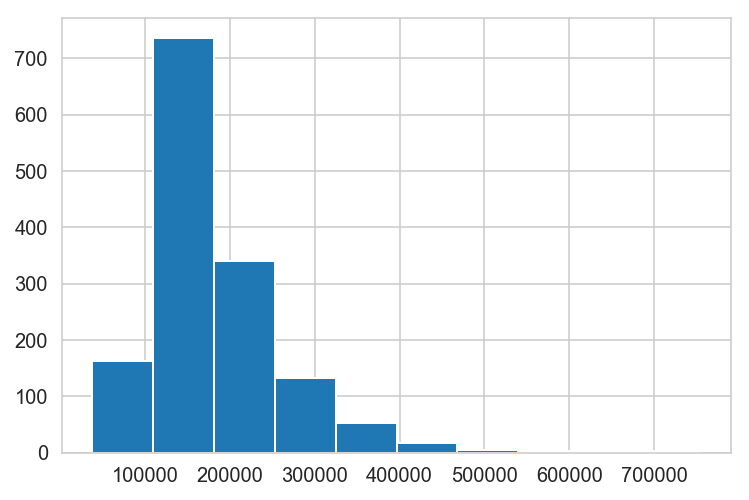

In [10]:
house_residential.SalePrice.hist()

In [11]:
house_residential.BsmtExposure.value_counts()

No    947
Av    219
Gd    134
Mn    112
NA     38
Name: BsmtExposure, dtype: int64

In [12]:
# item 948 basement exist, BsmtExposure change to No
house_residential.loc[house_residential.BsmtExposure=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0
371,NA,NA,NA,NA,0,NA,0,0,0,0


In [13]:
# setting 948, 'BsmtExposure' = 'No'
house_residential.loc[948, 'BsmtExposure'] = 'No'

In [14]:
# item 332 basement exist missing BsmtFinType2 
house_residential.loc[house_residential.BsmtFinType2=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NA,NA,NA,NA,0,NA,0,0,0,0
39,NA,NA,NA,NA,0,NA,0,0,0,0
90,NA,NA,NA,NA,0,NA,0,0,0,0
102,NA,NA,NA,NA,0,NA,0,0,0,0
156,NA,NA,NA,NA,0,NA,0,0,0,0
182,NA,NA,NA,NA,0,NA,0,0,0,0
259,NA,NA,NA,NA,0,NA,0,0,0,0
332,Gd,TA,No,GLQ,1124,NA,479,3206,1,0
342,NA,NA,NA,NA,0,NA,0,0,0,0
362,NA,NA,NA,NA,0,NA,0,0,0,0


In [15]:
# setting 332, 'BsmtFinType2' = 'othr'
house_residential.loc[332, 'BsmtFinType2'] = 'othr'

In [16]:
# some house missing masonry veneer type, set to NA, and 0
house_residential.loc[house_residential.MasVnrArea=='NA',['MasVnrType','MasVnrArea' ]]

,MasVnrType,MasVnrArea
234,NA,NA
529,NA,NA
650,NA,NA
936,NA,NA
973,NA,NA
977,NA,NA
1243,NA,NA
1278,NA,NA


In [17]:
house_residential.MasVnrArea = [0 if ele=='NA' else int(ele) for ele in house_residential.MasVnrArea]

In [18]:
# change None to NA
house_residential.loc[house_residential.MasVnrType=='None','MasVnrType']='NA'

In [19]:
# fit the missing electrical with the most common type SBrkr
house_residential.loc[house_residential.Electrical=='NA','Electrical']= house_residential.Electrical.value_counts().index[0]

In [20]:
house_residential.loc[house_residential.GarageYrBlt=='NA',['GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]


,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt
39,NA,NA,NA,NA,NA
48,NA,NA,NA,NA,NA
78,NA,NA,NA,NA,NA
89,NA,NA,NA,NA,NA
99,NA,NA,NA,NA,NA
108,NA,NA,NA,NA,NA
125,NA,NA,NA,NA,NA
127,NA,NA,NA,NA,NA
140,NA,NA,NA,NA,NA
148,NA,NA,NA,NA,NA


In [21]:
# set garageYrBlt to numerical, NA to 0, varified with GarageCond
house_residential.GarageYrBlt = [0 if ele=='NA' else int(ele) for ele in house_residential.GarageYrBlt]

In [22]:
house_residential['PorchSF'] = house_residential[['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

In [23]:
for col in house_residential.columns:
    if house_residential[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house_residential[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'FV' 'RH']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are ['NA' 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low' 'HLS']
For the column Utilities, the unique values are ['AllPub' 'NoSeWa']
For the column LotConfig, the unique values are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
For the column LandSlope, the unique values are ['Gtl' 'Mod' 'Sev']
For the column Neighborhood, the unique values are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
For the column Condition1, the unique values are ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
For the column C

In [24]:
house_residential.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,PorchSF
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,6.114483,5.582069,1971.593103,1985.049655,103.828276,445.162759,...,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069,86.604138
std,421.554345,42.265033,34.71992,10012.185355,1.372860,1.107330,30.022696,20.552319,181.150114,456.353871,...,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241,104.368794
min,1.000000,20.000000,0.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000,0.000000
25%,366.250000,20.000000,41.25000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000,0.000000
50%,731.500000,50.000000,63.00000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000,48.000000
75%,1096.750000,70.000000,79.00000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.000000,713.750000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,135.000000
max,1460.000000,190.000000,313.00000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,1027.000000


## Fixed ch selecting

In [25]:


fixed_ch = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
            'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'YearBuilt', 'YearRemodAdd',  'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
            'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars',
            'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
            '3SsnPorch', 'ScreenPorch','PorchSF','PoolArea',
            'MiscFeature', 'MiscVal']

In [26]:
rest_ch = [col for col in house_residential.columns if col not in fixed_ch]

In [27]:
rest_ch = rest_ch[1:-1]

In [28]:
rest_ch

['OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

## Review time factors

In [29]:
def p_year_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YrSold==year1, 'SalePrice'],house_residential.loc[ house_residential.YrSold==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')

        
def p_year_build_test(house_residential, year1, year2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.YearBuilt==year1, 'SalePrice'],house_residential.loc[ house_residential.YearBuilt==year2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {year1} and {year2} the p_value is {p_value}\n')        
        
        
        
def p_month_test(house_residential, m1, m2):

    t_stat, p_value = stats.ttest_ind(house_residential.loc[ house_residential.MoSold==m1, 'SalePrice'],house_residential.loc[ house_residential.MoSold==m2, 'SalePrice'])
    if p_value<0.05:
        print(f'Between {m1} and {m2} the p_value is {p_value}\n')

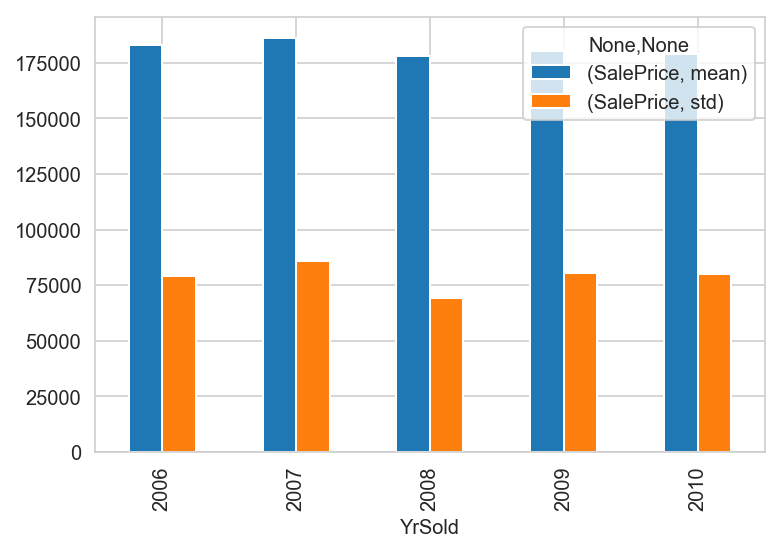

In [30]:
house_residential.groupby(['YrSold']).agg({'SalePrice': ['mean','std'] }).plot(kind='bar')

In [31]:
for year in range(2006,2011):
    for compare in range(year+1,2011):
        p_year_test(house_residential, year, compare)

In [32]:
for year in range(1950,2011):
    for compare in range(year+1,2011):
        p_year_build_test(house_residential, year, compare)

Between 1950 and 1960 the p_value is 0.006999309961260744

Between 1950 and 1964 the p_value is 0.0019898023011491015

Between 1950 and 1966 the p_value is 0.016036172417833224

Between 1950 and 1968 the p_value is 0.0027678743161151237

Between 1950 and 1969 the p_value is 0.008395118412309936

Between 1950 and 1974 the p_value is 0.001205281675727996

Between 1950 and 1976 the p_value is 0.003829503311702932

Between 1950 and 1977 the p_value is 0.0004173916377547709

Between 1950 and 1978 the p_value is 0.006518684319980653

Between 1950 and 1980 the p_value is 0.0167371288557425

Between 1950 and 1981 the p_value is 3.292807010855059e-05

Between 1950 and 1983 the p_value is 0.045815783936969424

Between 1950 and 1984 the p_value is 0.012397132311155848

Between 1950 and 1985 the p_value is 0.004018085628005743

Between 1950 and 1986 the p_value is 0.00019438595336002066

Between 1950 and 1987 the p_value is 0.0034311087920962887

Between 1950 and 1988 the p_value is 2.013488234219

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Between 1951 and 2007 the p_value is 0.00019281489380461138

Between 1951 and 2008 the p_value is 0.00012859491217742945

Between 1951 and 2009 the p_value is 0.00889762423633754

Between 1952 and 1964 the p_value is 0.013466820031048692

Between 1952 and 1974 the p_value is 0.048957809597974446

Between 1952 and 1977 the p_value is 0.035413362842357646

Between 1952 and 1981 the p_value is 0.029340575578824298

Between 1952 and 1986 the p_value is 0.023541723318021963

Between 1952 and 1987 the p_value is 0.03870382692428334

Between 1952 and 1988 the p_value is 0.0016684743658135124

Between 1952 and 1989 the p_value is 0.005156190345187543

Between 1952 and 1990 the p_value is 0.009670863644701159

Between 1952 and 1992 the p_value is 0.03129589747126209

Between 1952 and 1993 the p_value is 0.006905168127968954

Between 1952 and 1995 the p_value is 0.039084460566539775

Between 1952 and 1997 the p_value is 0.0015069343504795622

Between 1952 and 1998 the p_value is 0.00237353406173

Between 1958 and 1974 the p_value is 0.013617638643586264

Between 1958 and 1977 the p_value is 0.021450322318904837

Between 1958 and 1981 the p_value is 9.59062879678341e-05

Between 1958 and 1985 the p_value is 0.023842379786447543

Between 1958 and 1986 the p_value is 0.001475535759952345

Between 1958 and 1987 the p_value is 0.022384268180001336

Between 1958 and 1988 the p_value is 5.2986250146901725e-05

Between 1958 and 1989 the p_value is 4.929474122027515e-06

Between 1958 and 1990 the p_value is 3.260283946319936e-05

Between 1958 and 1991 the p_value is 0.04946816896292658

Between 1958 and 1992 the p_value is 0.0002462870087506521

Between 1958 and 1993 the p_value is 1.256499565424266e-05

Between 1958 and 1994 the p_value is 0.0013642601402158552

Between 1958 and 1995 the p_value is 5.242392946408722e-05

Between 1958 and 1996 the p_value is 0.0006070240593551375

Between 1958 and 1997 the p_value is 4.248229080312301e-06

Between 1958 and 1998 the p_value is 6.93841114

Between 1964 and 2005 the p_value is 0.002124439659853535

Between 1964 and 2006 the p_value is 5.383469040198645e-05

Between 1964 and 2007 the p_value is 5.898656876834775e-06

Between 1964 and 2008 the p_value is 3.5120295910849254e-07

Between 1964 and 2009 the p_value is 0.0008862599113022624

Between 1965 and 1981 the p_value is 0.004660047787466683

Between 1965 and 1986 the p_value is 0.049210035601724426

Between 1965 and 1988 the p_value is 0.011708229439782003

Between 1965 and 1989 the p_value is 0.0016902917325483746

Between 1965 and 1990 the p_value is 0.0028558848458219133

Between 1965 and 1992 the p_value is 0.006373648465053742

Between 1965 and 1993 the p_value is 0.0012966089674988305

Between 1965 and 1994 the p_value is 0.005418320788695102

Between 1965 and 1995 the p_value is 0.00043850759189794096

Between 1965 and 1996 the p_value is 0.002852003133111119

Between 1965 and 1997 the p_value is 0.0016501634530914086

Between 1965 and 1998 the p_value is 0.000153

Between 1972 and 2006 the p_value is 2.1079658851762635e-08

Between 1972 and 2007 the p_value is 2.5106247183381376e-09

Between 1972 and 2008 the p_value is 5.449035055759861e-10

Between 1972 and 2009 the p_value is 1.7330286103756038e-05

Between 1973 and 1981 the p_value is 0.006232976664360294

Between 1973 and 1986 the p_value is 0.02201424071815721

Between 1973 and 1988 the p_value is 0.002619148630818671

Between 1973 and 1989 the p_value is 0.001466078432752682

Between 1973 and 1990 the p_value is 0.0024744551505992167

Between 1973 and 1992 the p_value is 0.008013588030201309

Between 1973 and 1993 the p_value is 0.0013285295196557817

Between 1973 and 1994 the p_value is 0.023470426541253805

Between 1973 and 1995 the p_value is 0.003966598864635981

Between 1973 and 1996 the p_value is 0.01568400037327688

Between 1973 and 1997 the p_value is 0.0006466098724685374

Between 1973 and 1998 the p_value is 0.00023261451310175067

Between 1973 and 1999 the p_value is 0.0008386


Between 1981 and 1982 the p_value is 0.008146091601753995

Between 1981 and 1984 the p_value is 0.01791193273241567

Between 1982 and 1984 the p_value is 0.033819296669790014

Between 1982 and 1985 the p_value is 0.03637259093911111

Between 1982 and 1986 the p_value is 0.004597322333099851

Between 1982 and 1987 the p_value is 0.002059845244516437

Between 1982 and 1988 the p_value is 0.0001822330720709433

Between 1982 and 1989 the p_value is 0.0001766017401621276

Between 1982 and 1990 the p_value is 0.0028805017091883367

Between 1982 and 1992 the p_value is 0.014144719016742982

Between 1982 and 1993 the p_value is 0.0021564473269512965

Between 1982 and 1995 the p_value is 0.01756290739596871

Between 1982 and 1996 the p_value is 0.049024453295710056

Between 1982 and 1997 the p_value is 0.00024476013955518914

Between 1982 and 1998 the p_value is 0.0006091679060083547

Between 1982 and 1999 the p_value is 0.0016152347489669337

Between 1982 and 2000 the p_value is 7.14868509829

In [33]:
# keep the month column for renovate variable

for m1 in range(1,13):
    for m2 in range(m1+1,13):
        p_month_test(house_residential, m1, m2)

Between 4 and 9 the p_value is 0.040058419468244975

Between 4 and 11 the p_value is 0.043115189130592556

Between 5 and 9 the p_value is 0.018639526613212224

Between 5 and 11 the p_value is 0.020106790809764075



## Train test splite

In [34]:
train_data = house_residential[house_residential.YrSold< 2010 ].copy()
test_data = house_residential[house_residential.YrSold == 2010 ].copy()

In [35]:
(len(train_data)+len(test_data)) == len(house_residential)

True

In [36]:
print((len(train_data), len(test_data)))

(1278, 172)


## Get dummies

In [37]:
# for training set

fixed_predictor = train_data[fixed_ch]
y_train = train_data.SalePrice

In [38]:
object_col = [col for col in fixed_ch if fixed_predictor[col].dtype==object]
dummy_num_col = ['MSSubClass']
dummy_col = dummy_num_col + object_col
X_train = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object
np.argwhere(X_train.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [39]:
# for testing set

fixed_predictor = test_data[fixed_ch]
y_test = test_data.SalePrice
X_test = pd.get_dummies(fixed_predictor, columns=dummy_col, drop_first=True)
# no object
np.argwhere(X_test.dtypes == object)

array([], shape=(0, 1), dtype=int64)

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1278, 135), (1278,), (172, 115), (172,))

In [41]:
missing_col = [col for col in X_train.columns if col not in X_test.columns]
missing_col

['MSSubClass_45',
 'MSSubClass_75',
 'MSZoning_RH',
 'LotShape_IR3',
 'Utilities_NoSeWa',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Neighborhood_Veenker',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'GarageType_Attchd',
 'MiscFeature_NA',
 'MiscFeature_TenC']

In [42]:
[col for col in X_test.columns if col not in X_train.columns]

[]

In [43]:
missing_col_loc = [np.argwhere(X_train.columns==col)[0,0] for col in missing_col]

In [44]:
missing_col_loc

[30,
 34,
 42,
 49,
 54,
 57,
 61,
 84,
 93,
 95,
 96,
 97,
 98,
 99,
 104,
 106,
 107,
 123,
 131,
 134]

In [45]:
list(enumerate(X_train.columns))

[(0, 'LotFrontage'),
 (1, 'LotArea'),
 (2, 'YearBuilt'),
 (3, 'YearRemodAdd'),
 (4, 'MasVnrArea'),
 (5, 'TotalBsmtSF'),
 (6, '1stFlrSF'),
 (7, '2ndFlrSF'),
 (8, 'GrLivArea'),
 (9, 'BsmtFullBath'),
 (10, 'BsmtHalfBath'),
 (11, 'FullBath'),
 (12, 'HalfBath'),
 (13, 'BedroomAbvGr'),
 (14, 'KitchenAbvGr'),
 (15, 'TotRmsAbvGrd'),
 (16, 'Fireplaces'),
 (17, 'GarageYrBlt'),
 (18, 'GarageCars'),
 (19, 'GarageArea'),
 (20, 'WoodDeckSF'),
 (21, 'OpenPorchSF'),
 (22, 'EnclosedPorch'),
 (23, '3SsnPorch'),
 (24, 'ScreenPorch'),
 (25, 'PorchSF'),
 (26, 'PoolArea'),
 (27, 'MiscVal'),
 (28, 'MSSubClass_30'),
 (29, 'MSSubClass_40'),
 (30, 'MSSubClass_45'),
 (31, 'MSSubClass_50'),
 (32, 'MSSubClass_60'),
 (33, 'MSSubClass_70'),
 (34, 'MSSubClass_75'),
 (35, 'MSSubClass_80'),
 (36, 'MSSubClass_85'),
 (37, 'MSSubClass_90'),
 (38, 'MSSubClass_120'),
 (39, 'MSSubClass_160'),
 (40, 'MSSubClass_180'),
 (41, 'MSSubClass_190'),
 (42, 'MSZoning_RH'),
 (43, 'MSZoning_RL'),
 (44, 'MSZoning_RM'),
 (45, 'Street_Pave

In [46]:
for i,locnumber in enumerate(missing_col_loc):
    X_test.insert(loc=int(locnumber), column=missing_col[i], value=[0 for ele in range(X_test.shape[0])])

In [47]:
X_test.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
X_train.iloc[:, missing_col_loc].head()

,MSSubClass_45,MSSubClass_75,MSZoning_RH,LotShape_IR3,Utilities_NoSeWa,LotConfig_FR3,Neighborhood_Blueste,Neighborhood_Veenker,Condition2_Feedr,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,GarageType_Attchd,MiscFeature_NA,MiscFeature_TenC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


## Train and validation

In [49]:
# baseline

y_mean = y_train.mean()

r2_score(y_train, [y_mean for ele in y_train])

0.0

In [50]:
# model 1 LinearRegression
scaler1 = StandardScaler()
lr = LinearRegression()
X_train_std = scaler1.fit_transform(X_train)
score1 = cross_val_score(lr, X_train_std, y_train, scoring='r2', cv=10)
np.mean(score1), np.std(score1)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-7.140781558089344e+25, 2.1420244004482253e+26)

In [51]:
X_test_std = scaler1.transform(X_test)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [101]:
# model 2 Lasso
lassoCV = LassoCV(alphas=np.linspace(1000, 1050, 400), random_state=42, cv=10, max_iter=5000)
lassoCV.fit(X_train_std, y_train)
print(f'alpha is {lassoCV.alpha_}')
lasso = Lasso(alpha=lassoCV.alpha_, random_state=42, max_iter=5000)
score2 = cross_val_score(lasso, X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean is {np.mean(score2)}, the CV score std is {np.std(score2)}")
lasso.fit(X_train_std,y_train)
lasso.score(X_test_std,y_test)

alpha is 1025.9398496240601
The CV score mean is 0.79371067238939, the CV score std is 0.10438968058759135


0.8610178061768132

In [99]:
# model 3 ridge 
ridgeCV = RidgeCV(alphas=np.linspace(418, 425, 400), cv=10,scoring='r2')
ridgeCV.fit(X_train_std, y_train)
print(f'alpha is {ridgeCV.alpha_}')
ridge = Ridge(alpha=ridgeCV.alpha_,random_state=42, max_iter=5000)
score3 = cross_val_score(ridge,X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score3)}, the CV score std {np.std(score3)}")
ridge.fit(X_train_std,y_train)
ridge.score(X_test_std, y_test)

alpha is 421.49122807017545
The CV score mean 0.8000624643624464, the CV score std 0.09186118144098415


0.8595389594907679

In [69]:
# model 4 elasticNet
l1_ratios=np.linspace(0.001, 1, 100)
n_alpha = 1000

elasticNetCV = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=n_alpha, cv=10, max_iter=5000, random_state=42)
elasticNetCV.fit(X_train_std, y_train)

print(f"The l1 ration is {elasticNetCV.l1_ratio_}, the alpha is {elasticNetCV.alpha_}")
elasticNet = ElasticNet(alpha=elasticNetCV.alpha_, l1_ratio=elasticNetCV.l1_ratio_, max_iter=5000)
score4 = cross_val_score(elasticNet,X_train_std, y_train, scoring='r2', cv=10)
print(f"The CV score mean {np.mean(score4)}, the CV score std {np.std(score4)}")

elasticNet.fit(X_train_std, y_train)

elasticNet.score(X_test_std, y_test)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.001  , 0.01109, ..., 0.98991, 1.     ]),
       max_iter=5000, n_alphas=1000, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [90]:
# model 5 SelectKBest + LinearRegression

pipeline_KB_LR = Pipeline([("KB", SelectKBest()), ("LR", LinearRegression())])

print(f"Hyperparameter: {pipeline_KB_LR.get_params().keys()}")

KB_LR_parameter = {"KB__k": list(range(1,100)),
                  "KB__score_func": [f_regression, mutual_info_regression]}

KB_LR = GridSearchCV(pipeline_KB_LR, KB_LR_parameter, cv=10, scoring="r2" )
KB_LR.fit(X_train_std, y_train)

print(f"The best parameters are {KB_LR.best_params_}")

Hyperparameter: dict_keys(['memory', 'steps', 'KB', 'LR', 'KB__k', 'KB__score_func', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])


C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packa

The best parameters are {'KB__k': 79, 'KB__score_func': <function mutual_info_regression at 0x00000247F216E378>}


In [94]:
print(f"The CV score is {KB_LR.best_score_}")
KB_LR.refit
KB_lR_predict = KB_LR.predict(X_test_std)
r2_score(y_test, KB_lR_predict)

The CV score is 0.8063758009778853


In [83]:
# model 6 SelectKBest + Lasso (cv)

pipeline_KB_Lasso = Pipeline([("KB", SelectKBest()), ("Lasso", LassoCV())])

print(f"Hyperparameter: {pipeline_KB_Lasso.get_params().keys()}")

# KB_LR_parameter = {"KB__k": list(range(1,100)),
#                   "KB__score_func": [f_regression, mutual_info_regression]}

# KB_LR = GridSearchCV(pipeline_KB_LR, KB_LR_parameter, cv=10, scoring="r2" )
# KB_LR.fit(X_train_std, y_train)

# print(f"The best parameters are {KB_LR.best_params_}")




In [105]:
pickle.dump( [KB_LR, elasticNet, ridge, lasso], open( "save_resutl.p", "wb" ) )

In [107]:
loaded_model = pickle.load(open("save_resutl.p", 'rb'))

In [108]:
loaded_model

[GridSearchCV(cv=10, error_score='raise-deprecating',
        estimator=Pipeline(memory=None,
      steps=[('KB', SelectKBest(k=10, score_func=<function f_classif at 0x00000247F20D0378>)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False))]),
        fit_params=None, iid='warn', n_jobs=None,
        param_grid={'KB__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,...ction f_regression at 0x00000247F20D0510>, <function mutual_info_regression at 0x00000247F216E378>]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='r2', verbose=0),
 ElasticNet(alpha=56.56489665034848, copy_X=True, fit_intercept=True,
       l1_ratio=0.989909090909091, max_iter=5000, normalize=False,
    

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [56]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [57]:
# A: